In [ ]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
spark = SparkSession.builder.master("local[4]").getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
SPOTIPY_CLIENT_ID='ff464bf1719f4878a4c6b078329878fb'
SPOTIPY_CLIENT_SECRET='ccd5c137ece94d78b801a283b50f0340'
auth_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID,client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Help Functions

In [ ]:
from pyspark.ml.feature import PCA

# Function to get rows at `rownums`
def getrows(df, rownums=None):
    return df.rdd.zipWithIndex().filter(lambda x: x[1] > rownums[0] and x[1] < rownums[1]).map(lambda x: x[0])

def find_k(dataset , clusters = 20):
    """Trains a k-means model for muliply K's
    """
    """dataset: the dataframe to fit on Kmeans
       clusters: the number of clusters
    """
    data_graph = []
    for cluster in range(2, clusters):
        kmeans = KMeans().setK(cluster).setSeed(1)
        model = kmeans.fit(dataset)
        # Make predictions
        predictions = model.transform(dataset)
        # Evaluate clustering by computing Silhouette score
        evaluator = ClusteringEvaluator()
        #Calculate silhouette
        silhouette = evaluator.evaluate(predictions)
        data_graph.append((cluster,silhouette))
    return data_graph

def plot_silhouettes(data):
    #Find the optimal K for clustering
    """plot the silhouette for every cluster
    """
    """data: the dataframe to fit to Kmeans 
    """
    data_graph = find_k(data)
    model_df = sc.parallelize(data_graph).toDF(["k", "silhouette"])
    topandas_df = model_df.toPandas()
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.barplot(x="k", y="silhouette", data=topandas_df)


def my_pca(train_df, test_df,num_features):
    """my_pca train an PCA algorithm on the train_df and apllies
       it on train_df and test_df which is part of train_df
    """
    """train_df: training data frmae
       test_df:  test dataframe (part of the train dataframe)
       num_features: the dimension to reduce
       ------------
       return trainData train_df after PCA dimensional reduction
              testData tesd_df after Pca dimensional reduction
    """
    #Train PCA Algorithmn
    pca = PCA(k=num_features, inputCol = 'features' , outputCol = 'pcaFeatures')
    model = pca.fit(train_df)
    
    #Train Data to Kmeans
    trainData = model.transform(train_df).select("pcaFeatures")
    trainData = trainData.rdd.map(lambda row: row).toDF(["features"])

    #Test Data to Kmeans
    testData = model.transform(test_df).select("pcaFeatures")
    testData = testData.rdd.map(lambda row: row).toDF(["features"])
    return trainData, testData

def my_kmeans(trainData, testData, k):
    """trainData: training datafrmae
       testData: test dataframe which is part from the train dataframe
       k: number of cluster to seek
       ---------
       return  predictionsTrain( the trainData with Kmeans predictions), 
               predictionsTest( the testData with Kmeans predictions),
               centers_list (clusters centers)
    """
    center_x = []
    center_y = []
    centers_list = []
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(trainData)
    predictionsTrain = model.transform(trainData)
    predictionsTest = model.transform(testData)
    centers = model.clusterCenters()
    for center in centers:
        center_x.append(center[0])
        center_y.append(center[1])
    centers_list.append(center_x)
    centers_list.append(center_y)
    return predictionsTrain, predictionsTest ,centers_list

#Plot Data points for 2 dimension dataframe
def display_graph(train_df,test_df , centers):
    train_collected = train_df.collect()
#   test_collected = test_df.collect()
    dim_x = []
    dim_y = []
    dim_x_test = []
    dim_y_test = []
    
    cluster_x0 = []
    cluster_x1 = []
    cluster_x2 = []
    cluster_x3 = []
    cluster_x4 = []
    cluster_x5 = []
    
    cluster_y0 = []
    cluster_y1 = []
    cluster_y2 = []
    cluster_y3 = []
    cluster_y4 = []
    cluster_y5 = []
    
    
    for row in train_collected:
        if row[1] == 0:
            cluster_x0.append(row[0][0])
            cluster_y0.append(row[0][1])
        elif row[1] == 1:
            cluster_x1.append(row[0][0])
            cluster_y1.append(row[0][1])
        elif row[1] == 2:
            cluster_x2.append(row[0][0])
            cluster_y2.append(row[0][1])
        elif row[1] == 3:
            cluster_x3.append(row[0][0])
            cluster_y3.append(row[0][1])
        elif row[1] == 4:
            cluster_x4.append(row[0][0])
            cluster_y4.append(row[0][1])
        else:
            cluster_x5.append(row[0][0])
            cluster_y5.append(row[0][1])
            
    plt.scatter(cluster_x0, cluster_y0,label='cluster 1',color='yellow')
    plt.scatter(cluster_x1, cluster_y1,label='cluster 2',color='green')
    plt.scatter(cluster_x2, cluster_y2,label='cluster 3',color='blue')
    plt.scatter(cluster_x3, cluster_y3,label='cluster 4',color='purple')
    plt.scatter(cluster_x4, cluster_y4,label='cluster 5',color='pink')
    plt.scatter(cluster_x5, cluster_y5,label='cluster 6',color='black')
    plt.scatter(centers[0],centers[1],label = 'centers', color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Clustering after PCA of Two dimensions')
    plt.legend()
    plt.show()

# Combine multiple datasets with Pandas

In [ ]:
dataset1 = pd.read_csv("spotify_dataset.csv")
dataset2 = pd.read_csv("spotify_dataset1.csv")
dataset3 = pd.read_csv("spotify_dataset2.csv")
tracks_df = dataset1.append(dataset2).append(dataset3)
tracks_df[["danceability", "energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]] = tracks_df[["danceability", "energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]].apply(pd.to_numeric)
tracks_df.drop('Unnamed: 0',axis='columns').drop_duplicates().reset_index(drop=True).to_csv('sp_dataset.csv')

In [ ]:
tracks_df.dtypes

# Read Spotify dataset file with spark

In [ ]:
schema = StructType([
    StructField('index', StringType(), False),
    StructField('danceability', DoubleType(), False),
    StructField('energy', DoubleType(), False),
    StructField('key', IntegerType(), False),
    StructField('loudness', DoubleType(), False),
    StructField('mode', IntegerType(), False),
    StructField('speechiness', DoubleType(), False),
    StructField('acousticness', DoubleType(), False),
    StructField('instrumentalness', DoubleType(), False),
    StructField('liveness', DoubleType(), False),
    StructField('valence', DoubleType(), False),
    StructField('tempo', DoubleType(), False),
    StructField('type', StringType(), False),
    StructField('id', StringType(), False),
    StructField('uri', StringType(), False),
    StructField('track_href', StringType(), False),
    StructField('analysis_url', StringType(), False),
    StructField('duration_ms', IntegerType(), False),
    StructField('time_signature', IntegerType(), False),
    StructField('popularity', IntegerType(), False),
    StructField('track_name', StringType(), False),
    StructField('artist_name', StringType(), False),
])

tracks_df = spark.read.csv("sp_dataset.csv",schema=schema)
existing = tracks_df.columns
new_names = ['index','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature','popularity','track_name','artist_name']
for old , new in zip(existing,new_names):
    tracks_df = tracks_df.withColumnRenamed(old,new)

In [ ]:
tracks_df.printSchema()

root
 |-- index: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- uri: string (nullable = true)
 |-- track_href: string (nullable = true)
 |-- analysis_url: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- track_name: string (nullable = true)
 |-- artist_name: string (nullable = true)



In [ ]:
train_df = getrows(tracks_df,[1,9018]).toDF()
test_df = getrows(tracks_df,[9018,11000]).toDF()
df_to_stream = getrows(tracks_df,[11000,11273]).toDF()

Creation of future stream Data

In [ ]:
columns_to_drop = [column for column in df_to_stream.columns if column not in ['uri', 'track_name']]
df_to_stream = df_to_stream.select("uri", 'track_name')
df_to_stream.repartition(1).write.format('csv').save('/home/afeka/Desktop/DataToStream')

Extracting Relevent data 

In [ ]:
track_namesRDD = train_df.rdd.map(lambda track: (track['track_name'],track['artist_name']))
track_names = track_namesRDD.collect()

In [ ]:
audio_trainRDD = train_df.rdd.map(lambda x: (x['danceability'],x['energy'],x['key'],x['loudness'],x['mode'],x['speechiness'],x['acousticness'],x['instrumentalness'],x['liveness'],x['valence'],x['tempo']))
audio_testRDD = test_df.rdd.map(lambda x: (x['danceability'],x['energy'],x['key'],x['loudness'],x['mode'],x['speechiness'],x['acousticness'],x['instrumentalness'],x['liveness'],x['valence'],x['tempo']))

Normalize The Data

In [ ]:
# divide tempo by 100 then normalize the data
audio_normal_trainRDD = audio_trainRDD.map(lambda x: (x[0],x[1],x[3],x[5],x[6],x[7],x[8],x[9],float(x[10])/100))\
                       .map(lambda x: [float(i/np.linalg.norm(x)) for i in x])
audio_normal_testRDD = audio_testRDD.map(lambda x: (x[0],x[1],x[3],x[5],x[6],x[7],x[8],x[9],float(x[10])/100))\
                       .map(lambda x: [float(i/np.linalg.norm(x)) for i in x])

Create DataFrame from tracks features

In [ ]:
schema = StructType([
    StructField('danceability', FloatType(), False),
    StructField('energy', FloatType(), False),
    StructField('loudness', FloatType(), False),
    StructField('speechiness', FloatType(), False),
    StructField('acousticness', FloatType(), False),
    StructField('instrumentalness', FloatType(), False),
    StructField('liveness', FloatType(), False),
    StructField('valence', FloatType(), False),
    StructField('tempo', FloatType(), False),
])

audio_normal_train_DF = audio_normal_trainRDD.map(lambda x: x).toDF(schema=schema)
audio_normal_test_DF = audio_normal_testRDD.map(lambda x: x).toDF(schema=schema)
audio_normal_train_DF

danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0.073392764,0.07524181,-0.9752988,0.0035842978,0.012772617,1.1677415E-4,0.011293383,0.024037553,0.19199747
0.061215293,0.08170631,-0.9827954,0.0039048914,0.022424128,1.7655779E-4,0.01469167,0.06108642,0.138652
0.05138344,0.01853334,-0.9861894,0.003049666,0.09698134,0.009080356,0.0127478,0.009178416,0.121255115
0.055040475,0.03268028,-0.9879335,0.0034185294,0.031712774,6.686558E-5,0.012685109,0.01849016,0.13553502
0.07815054,0.06124511,-0.96983784,0.0049085063,0.012367656,0.0,0.015719084,0.021354228,0.22062625
0.1136671,0.16275062,-0.94689465,0.008644263,1.2340432E-4,6.418614E-4,0.032788586,0.12082097,0.21962391
0.087949015,0.22417866,-0.83225346,0.02766349,0.012631253,0.0,0.05297819,0.069158725,0.49076334
0.034399554,0.031793527,-0.99274725,0.005897066,0.06649091,0.0075202486,0.027549425,0.035441965,0.075705074
0.07706353,0.08475805,-0.9787424,0.003847258,0.046167094,8.937476E-7,0.008807261,0.101922736,0.12778342
0.111829795,0.17944781,-0.94765246,0.013563613,3.8610288E-4,0.001636436,0.041411035,0.15144035,0.18003197


# Correlation Matrix

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
columns = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo']

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=columns, outputCol=vector_col)
df_vector = assembler.transform(audio_normal_train_DF).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

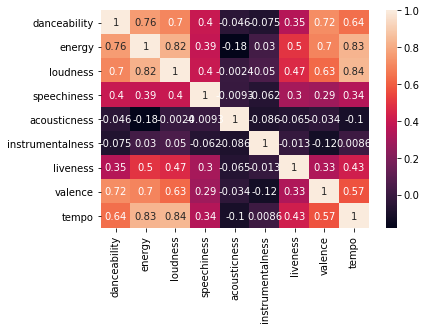

In [ ]:
sn.heatmap(corrmatrix, annot=True,xticklabels=columns,yticklabels=columns)
plt.show()

# Find optimal K for Kmeans algorithm

# New Section

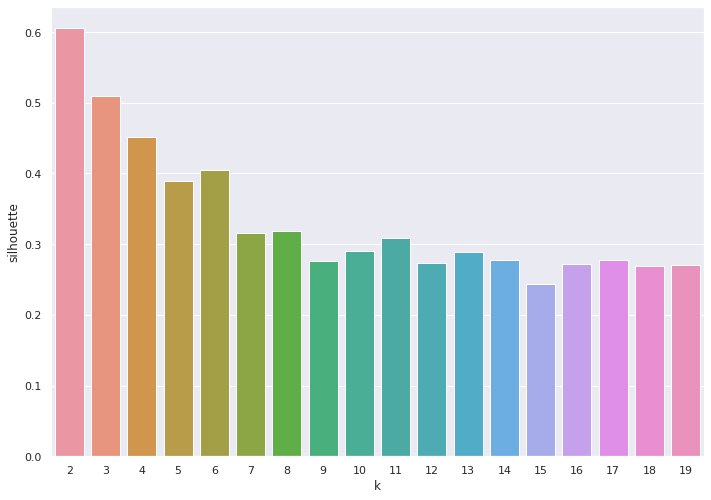

In [ ]:
from numpy import array

from math import sqrt
from pyspark.sql.types import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

normal_train_df = audio_normal_train_DF.rdd.map(lambda row: Row(Vectors.dense([row[0], row[1], row[2], row[3], row[4],row[5],row[6],row[7],row[8]]))).toDF(["features"])
normal_test_df = audio_normal_test_DF.rdd.map(lambda row: Row(Vectors.dense([row[0], row[1], row[2], row[3], row[4],row[5],row[6],row[7],row[8]]))).toDF(["features"])

plot_silhouettes(normal_train_df)

# PCA

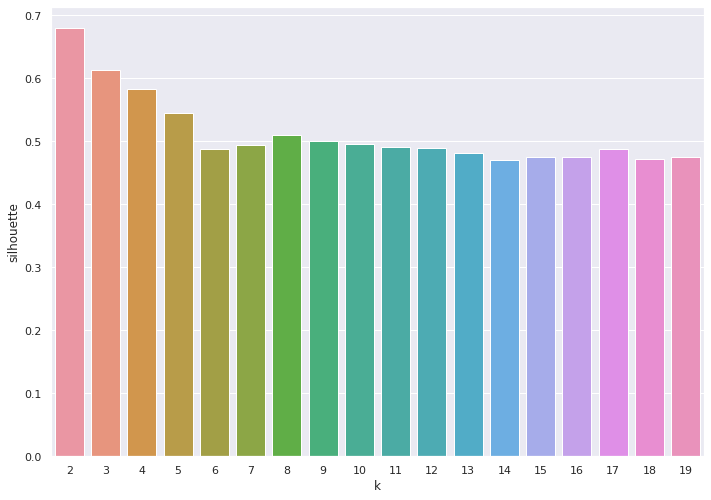

In [ ]:
trainData ,testData = my_pca(normal_train_df, normal_test_df, 2)
plot_silhouettes(trainData)

Train the data

In [ ]:
#train_predictions, test_predictions, centers = my_kmeans(trainData, testData, k=6)
center_x = []
center_y = []
centers_list = []
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(trainData)
predictionsTrain = model.transform(trainData)
predictionsTest = model.transform(testData)
centers = model.clusterCenters()
for center in centers:
    center_x.append(center[0])
    center_y.append(center[1])
centers_list.append(center_x)
centers_list.append(center_y)

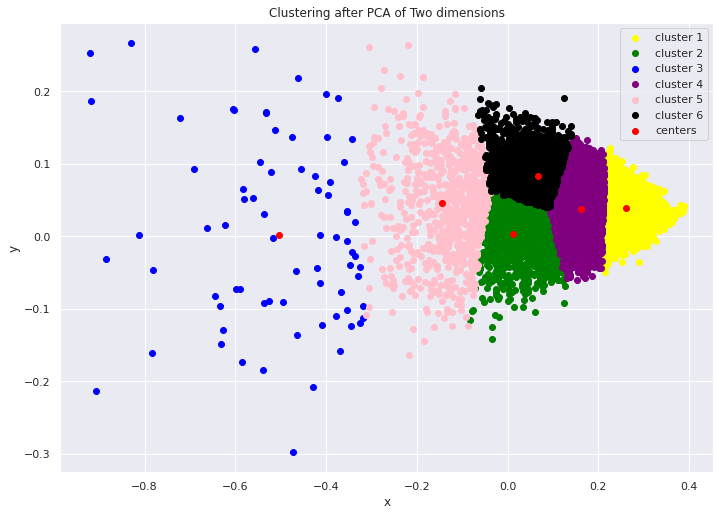

In [ ]:
display_graph(train_predictions, test_predictions, centers_list)